# Creating gymnasium environment

### How to adapt this notebook to your environment ?

DQN :
- The input size of the nn depends on the size of the input state : adapt the size of the first layer 

Env: 
- Don't modify :
    - policy 
    - random_action 

- Modify :
    - init :
        - n_action : we assume the action space to be finite, and we hope small 
        - done : this attribute say if the episode is finished, it needs to be set to true when we do the reset, and we need to update in the function step
        - every attribute you need to build the function step, state, show_state
    - state : must return a batch of size 1 : 
        - typically our state is a vector of size say d, so a tensor of size (d). Here we want the function 
            to return a batch of size one , so we return a vector of size (1,d) e.g [t] where t is our size 
    - show_state 
    - reset : must update the attribute done, and your internal attribute that give the current state of the episode
    - step : take an action as a tensor (we access it by action.item() ) and returns a namedtuple Transition 
    with 4 coordinates (state,action,next_state,reward) 
            - every reward must be in [0,1] to make easier the hyperparameter finetuning
            - state and next_state must be a batch of size one (as for the function state)
            - action should be a batch of size one
            - if the episode is finished after the action, next_state must be None

### Explanations

The environment is:
 - A $N \times M$ grid of cases with $N,M \in \mathbb{N}$ supposed to be a loop track.
 - Each case is in $\{0,1,3,4\}$ such that:
   - $0 \rightarrow$ road (white)
   - $1 \rightarrow$ wall (black)
   - $STAR\_ CHAR$ (3) $\rightarrow$ starting point

 - A Car that follow some model for trajectory. The car can do the next action:
   - accelerate (add $1$ to car speed)
   - brake (divide the car speed by $1.5$)
   - turn (need to specify the angle)
   - do nothing
  
 - Possible Actions $(a,b) \in \{-1,0,1\} \times [-K,K]$ where:
   - $a=1$ for acceleration, $-1$ for brake and $0$ for nothing
   - $b>0$ for turning left with angle, $b<0$ to turn right and 0 for nothing. Note that a turn, in this environment is always in $[-K,K]$ where $K$ is the value of `env.max_turn` variable.

 - The state is a $8$ vector $V$
   - $V[0]$ is the speed of the car $\geq 0$
   - $V[i]$ (for $i \in [8]$) is the distance to the wall with rotation $90 - 30i$


To create your turn/your track, use the grid notation (for better visualisation) like env_01 and env_02. The grid is used with the matrix notation. If we denote the grid by $G$, then $G[0][0]$ is the top left case, $G[x][y]$ is the case on the $x$-th row (from top to bottom) and on the $y$-th column (from left to right).

You can also use image for that with balck pixel for wall, white for starting point, any other color will be interpreted as road.

Nevertheless, for all the other things, we use axis coordinates, i.e., $G[x][y]$ refer to the case situate at coordinate $(x,y)$. More preciselly, it is the case on the $x$-th column (from left to right) and on the $y$-th row (from bottom to top). Therefore you can simply use `plt.plot(x,y, args**)` for ploting something at coordinate $(x,y)$ (see code for more example).

### Importing Packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

# For saving files
from datetime import datetime

### Coor class

In [7]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

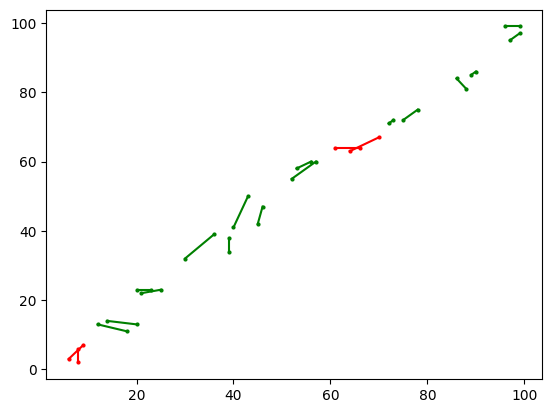

In [8]:
def intersect(coorA,coorB,coorC,coorD):
    # Return true if line segments AB and CD intersect
    def ccw(coorA, coorB, coorC):
        return (coorC.y-coorA.y) * (coorB.x-coorA.x) > (coorB.y-coorA.y) * (coorC.x-coorA.x)
    return ccw(coorA,coorC,coorD) != ccw(coorB,coorC,coorD) and ccw(coorA,coorB,coorC) != ccw(coorA,coorB,coorD)

n = 10
random_coor = lambda a,b : Coor((rd.randint(a,b), rd.randint(a,b)))
for i in range(10):
    a = random_coor(i*n, (i+1)*n)
    b = random_coor(i*n, (i+1)*n)
    c = random_coor(i*n, (i+1)*n)
    d = random_coor(i*n, (i+1)*n)
    color = "green"
    if intersect(a,b,c,d):
        color = "red"
    plt.plot([a.x, b.x], [a.y,b.y], "-o", color=color, markersize=2)
    plt.plot([c.x, d.x], [c.y,d.y], "-o", color=color, markersize=2)
plt.show()

In [9]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
CAR_CHAR = 4

def color_track(b):
    if b == START_CHAR:
        return GREEN
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab, l_bt_lines=8, nb_lines=1):
        """ Track class
        
        l_bt_lines is the space between two lines

        nb_lines is tej inverse of the ratio you want to keep each lines
        i.e. nblines=n => keep on 1/n lines
        """

        #switching height and width for plan approach
        self.height, self.width = np.array(tab).shape
        self.basic_info_track:list = np.array(tab)
        
        self.info_track:list = [[0 for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color_track(self.info_track[x][y]) for x in range(self.width)] for y in range(self.height)]

        self.start = None
        for y in range(self.height):
            for x in range(self.width):
                if self.info_track[x][y] == START_CHAR:
                    self.start = Coor((x,y))

        self.basic_alpha = 0
    
        self.nb_lines = nb_lines
        self.lenght_bt_lines = l_bt_lines
        self.midpoints, self.lines = self.create_lines(self.start)
        self.lines = [x for i,x in enumerate(self.lines) if i%nb_lines==0]
        

    def create_lines(self, coor:Coor):
        liste_coor = [coor]
        lines = []
        alpha = 0

        running = True
        while True:
            line, next_alpha, new_coor = self.create_line(liste_coor[-1])
            #plt.plot(liste_coor[-1].x, liste_coor[-1].y, "o", color="limegreen", markersize=3)
            liste_coor[-1] = new_coor

            coor_alpha = Coor((np.cos(alpha*np.pi/180), np.sin(alpha*np.pi/180)))
            coor_next_alpha = Coor((np.cos(next_alpha*np.pi/180), np.sin(next_alpha*np.pi/180)))
            if coor_alpha.x*coor_next_alpha.x + coor_alpha.y*coor_next_alpha.y<0:
                next_alpha = (next_alpha + 180) %360

            dx = np.cos(next_alpha*np.pi/180) * self.lenght_bt_lines
            dy = np.sin(next_alpha*np.pi/180) * self.lenght_bt_lines
            next_coor = Coor((dx,dy)) + liste_coor[-1]
            

            liste_coor.append(next_coor)
            lines.append(line)
            alpha = next_alpha
            
            if (not running) and intersect(new_coor, next_coor, lines[0][0], lines[0][1]):
                break
            running = False
            
        return liste_coor, lines


    def create_line(self, base_coor):
        min_lenght = self.height + self.width
        for alpha in range(0, 180):
            coor1_act = self.next_wall(base_coor, alpha)
            coor2_act = self.next_wall(base_coor, alpha+180)
            lenght_act = coor1_act.dist(coor2_act)

            if lenght_act<min_lenght:
                coor1 = Coor((coor1_act.x, coor1_act.y))
                coor2 = Coor((coor2_act.x, coor2_act.y))
                min_lenght = lenght_act
                basic_alpha = alpha-90

        return (coor1, coor2), basic_alpha, Coor(((coor1.x + coor2.x)/2, (coor1.y + coor2.y)/2 ))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color_track(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        x,y = int(round(x)), int(round(y))
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)
    
    def is_move_possible(self, a:Coor, b:Coor) -> bool:
        """Return if the car can go from point a to b in straight line"""
        diff_x = b.x-a.x
        diff_y = b.y-a.y

        d = a.dist(b)
        if d<1:
            d = 1
        
        space = np.arange(0, 1, 1/d)
        for t in space:
            case = Coor((a.x+t*diff_x, a.y+t*diff_y))
            if not self.is_case_ridable(case):
                return False
        return True
    
    def is_case_in(self, coor:Coor):
        """return True is coor is in the tab"""
        return coor.x>=0 and coor.x<self.width and coor.y>=0 and coor.y<self.height
    
    def next_road(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while not self.is_case_ridable(next_coor):
            if ((dist_max!=None) and (coor.dist(next_coor) > dist_max)) or (not self.is_case_in(next_coor)):
                return None
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def next_wall(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while self.is_case_ridable(next_coor):
            if (dist_max!=None) and (coor.dist(next_coor) > dist_max):
                break
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def plot(self, hide=False, show_lines=False, show_midpoints=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')

        if show_lines:
            for i in self.lines:
                liste_x = [coor.x for coor in i]
                liste_y = [coor.y for coor in i]
                plt.plot(liste_x, liste_y, '-', color="lightblue")

        if show_midpoints:
            for i in self.midpoints:
                plt.plot(i.x, i.y, 'o', color="lightblue", markersize=3)

        plt.plot(self.start.x, self.start.y, "o", color="limegreen")
            
        plt.axis("off")
        if not hide:
            plt.show()


### Creating tracks

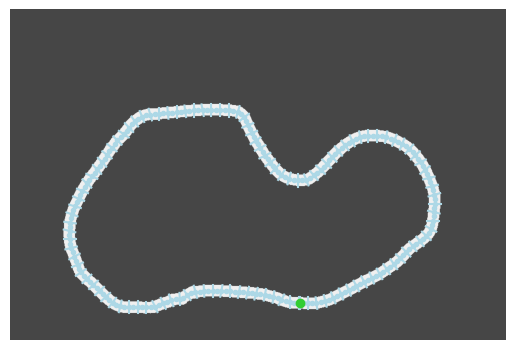

114


In [10]:
path = "../tracks/02.png"

from matplotlib.image import imread
from PIL import Image

def info_from_real_color(tab):
    x,y,z = tab[0], tab[1], tab[2]
    if x==0 and y==0 and z==0:
        return 1
    elif np.sqrt((x-255)**2 + (y-255)**2 + (z-255)**2) <= 20:
    #elif x==255 and y==255 and z==255:
        return START_CHAR
    else:
        return 0
    
def crop(tab):
    start = None
    for i,x in enumerate(tab):
        for j,y in enumerate(x):
            if y==START_CHAR:
                start = Coor((i,j))
    mini = Coor((start.x, start.y))
    maxi = Coor((start.x, start.y))

    for i,x in enumerate(tab):
        for j,y in enumerate(x):
            if y==0:
                if i<mini.x:
                    mini.x = i
                if j<mini.y:
                    mini.y = j
                if i>maxi.x:
                    maxi.x = i
                if j>maxi.y:
                    maxi.y=j
    
    k = 2
    res = [[y for j,y in enumerate(x) if mini.y-k<=j<=maxi.y+k] for i,x in enumerate(tab) if mini.x-k<=i<=maxi.x+k]
    return res

def create_track_info(path):
    img = Image.open(path)
    arr = np.array(img)
    img.close()
    return crop([[info_from_real_color(y) for y in x] for x in arr])

basic_track = Track(create_track_info("../tracks/02.png"), nb_lines=2, l_bt_lines=8)
basic_track.plot(show_lines=True, show_midpoints=True)

In [ ]:
from os import walk

tracks_folder = "../tracks2/post_images/"
paths = []
for (dirpath, dirnames, filenames) in walk(tracks_folder):
    for file in filenames:
        file_path = tracks_folder + file
        paths.append(file_path)
    break

paths.sort()
del paths[8]
print("Number of tracks:", len(paths))
print(paths)

# put all the tracks path here:
# The track called O3.png is not working because of unsmooth corner
tracks: list[Track] = []
for name in paths:
    track_info = create_track_info(name)
    tracks.append(Track(track_info, nb_lines=2, l_bt_lines=8))
    tracks[-1].plot(show_lines=True, show_midpoints=True)
    print(name, "as", len(tracks[-1].lines), "lines")

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [11]:
"""Constant"""
MAX_SPEED = 50
MAX_TURN = 20

"""Class"""
class Car():
    def __init__(self, coor:Coor, time):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [[Coor((coor.x, coor.y)), 0]]
        self.previous_speed: float = 0
        self.time = time

        self.max_turn = 20 * self.time
        self.max_speed = 50 * self.time
        self.acceleration_constant = 3 * self.time
        self.brake_constant = 6 * self.time

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        self.speed += amont * self.acceleration_constant
        self.speed = min(self.speed, self.max_speed)
        

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        self.speed -= amont * self.brake_constant
        if self.speed < 0:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        if np.absolute(deg) > self.max_turn:
            print(deg)
            assert False
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        speed_increase = 0
        if self.previous_speed < self.speed:
            speed_increase = 1
        elif self.previous_speed > self.speed:
            speed_increase = -1
        self.previous_speed = self.speed

        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append([Coor((self.coor.x, self.coor.y)), speed_increase])

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [i[0].x for i in self.trajectory]
            liste_y = [i[0].y for i in self.trajectory]

            for i in range(1, len(self.trajectory)):
                color = "yellow"
                if self.trajectory[i][1] == 1:
                    color = "green"
                elif self.trajectory[i][1] == -1:
                    color = "red"
        
                plt.plot([liste_x[i-1], liste_x[i]], [liste_y[i-1], liste_y[i]], "-o", color=color, markersize=2)
                 
        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")
        plt.plot(x, y, "o", color='blue', markersize=markersize)


### Gym env

We need to transform a actual action $(a, \alpha) \in \{-1,0,1\} \times \{-K,...,K\}$ where $K =$ `MAX_TURN` to a action in $\{0,...,N-1\}$.

Then we need a bijection
$$\phi : \{-1,0,1\} \times \{-K,...,K\} \rightarrow \mathbb{Z}_N$$

We can take
$$\phi(a,b) = 3(b+K) + (a+1)$$

Then,
$$\phi^{-1}(x) = ((x\; mod\; 3)-1, \frac{1}{3}x -K)$$

Moreover, we have $N = 3\times 2K+1 = 6K+3$

In [12]:
MAX_SPEED = 50
MAX_TURN = 20

class RacingCar(Env):
    def __init__(self):
        super(RacingCar, self).__init__()
        # time between two frames
        self.time = 0.9 #Change this variable to "discretiser" the time. Lower value means more discretisation

        self.max_turn = int(MAX_TURN * self.time)
        self.nb_state = 6*self.max_turn + 3
        self.max_speed = int(MAX_SPEED * self.time)

        # Define an action space ranging from 0 to 3
        self.action_space = [self.int_to_action(i) for i in range(self.nb_state)]
        self.int_action_space = [i for i in range(self.nb_state)]

        self.track: Track = None
        self.id_line_goal = 0

        # Define the anle of which we will look the distance
        self.liste_alpha = [60, 40, 20, 0, -20, -40, -60]
        self.max_dist_wall = None

        self.reward_max = 200
        
        self.car: Car = None

    def create_car(self):
        car = Car(self.track.start, self.time)
        return car

    def action_to_int(self, action):
        """Transform an action (tuple) into an action (int)"""
        a,b = action
        return 3*(b+self.max_turn) + a+1
    
    def int_to_action(self, x):
        """Transform an action (int) into an action (tuple)"""
        return ((x%3)-1, int(x/3) -self.max_turn)


    def get_state(self):
        """Return actual state of the env"""
        state = [self.car.speed]
        for alpha in self.liste_alpha:
            coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
            state.append(self.car.coor.dist(coor))
        return state

    def reset(self, track):
        """Reset the environment"""
        self.id_line_goal = 0
        self.track = track
        self.max_dist_wall = self.track.height + self.track.width

        self.car = self.create_car()
        return self.get_state(), []

    def render(self, waiting_time=0.01,
               show_trajectory=False, show_dist_to_wall=False,
               show_track_midpoint=False, show_track_lines=False):
        """Render the environment"""
        self.track.plot(hide=True, show_lines=show_track_lines, show_midpoints=show_track_midpoint)
        if show_dist_to_wall:
            for alpha in self.liste_alpha:
                coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
                plt.plot([self.car.coor.x, coor.x], [self.car.coor.y, coor.y], "-", color="grey")

        self.car.plot(show_trajectory=show_trajectory)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
    def step(self, action:int):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = 0

        x,y = self.car.coor.get()
        previous_coor = Coor((x,y))

        acc, turn = self.int_to_action(action)
        if acc==-1:
            self.car.brake()
        elif acc==1:
            self.car.accelerate()
        self.car.turn(turn)
        self.car.move()

        new_coor = self.car.coor

        has_crashed = False
        if not self.track.is_move_possible(previous_coor, new_coor):
            has_crashed = True
            reward -= 500
            is_done = True

        if self.car.speed == 0:
            reward -= 10
        
        reward += self.car.speed/self.max_speed
        
        previous_id = (self.id_line_goal-1) % (len(self.track.lines))

        if intersect(self.track.lines[previous_id][0], self.track.lines[previous_id][1], previous_coor, new_coor):
            reward -= 200
            is_done = True

        while intersect(self.track.lines[self.id_line_goal][0], self.track.lines[self.id_line_goal][1], previous_coor, new_coor) and not has_crashed:
            reward += 10
            self.id_line_goal = (self.id_line_goal + 1) % (len(self.track.lines))

        reward -= 1
        return self.get_state(), reward, is_done, has_crashed, []
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = ((-1)**(rd.randint(0,1))) * rd.randint(-self.max_turn, self.max_turn)
        return tuple(action)

# NEAT

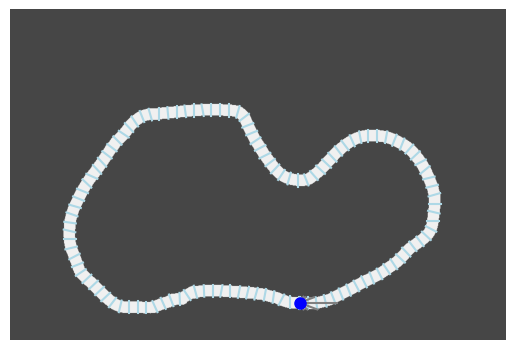

111


In [13]:
env = RacingCar()
env.reset(tracks[0])
env.render(show_dist_to_wall=True, show_track_lines=True)
print(env.nb_state)

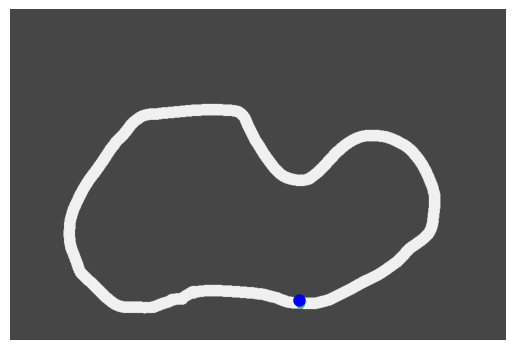

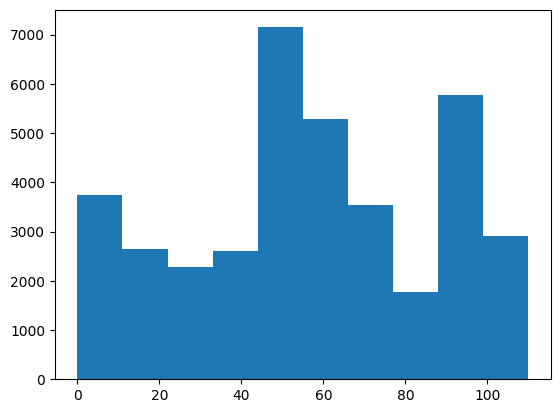

Best genome of generation 5: -238.88

 ****** Running generation 6 ****** 



KeyboardInterrupt: 

In [14]:
import neat

generation_act = 0

def softmax(x):
    e_x = np.exp(x - np.max(x))  # To avoid overflow
    return e_x / e_x.sum()

liste_action = []
def evaluate_genome(genome, config, show=False):
    # Create a neural network from the genome
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    
    # Initialize the environment
    obs, _ = env.reset(tracks[0])
    total_reward = 0.0
    done = False

    max_step = 170
    step = 0
    while (not done) and (step < max_step):
        step += 1
        # Neural network decides the action
        if (generation_act < 5):
            action_probs = softmax(net.activate(obs))
            action = np.random.choice(len(action_probs), p=action_probs)
        else:
            action = np.argmax(net.activate(obs))  # Choose the action with the highest output
        liste_action.append(action)

        obs, reward, done, _, _ = env.step(action)
        if show:
            env.render(show_trajectory=True)
        total_reward += reward
    
    #print("REWARD:", total_reward)
    return total_reward -step/2



def evaluate_population(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = evaluate_genome(genome, config)


path_config = "./RacingCar.config"

# Load configuration
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                    neat.DefaultSpeciesSet, neat.DefaultStagnation,
                    path_config)


NB_GEN = 40
def run_neat():
    # Create the population
    population = neat.Population(config)

    # Add a reporter to display progress in the terminal
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)

    # Run NEAT
    #winner = population.run(evaluate_population, n=NB_GEN)

    best_genome_per_gen = []
    for generation in range(NB_GEN):
        global generation_act
        generation_act = generation
        population.run(evaluate_population, n=1)

        # Store the best genome of this generation
        best_genome = population.best_genome
        best_genome_per_gen.append((best_genome, best_genome.fitness))

        if (generation+1) % 10 == 0 or generation==5:
            evaluate_genome(best_genome, config, show=True)
            plt.hist(liste_action)
            plt.show()
        
        print(f"Best genome of generation {generation}: {best_genome.fitness}")

    # Return the list of best genomes of each generation
    return best_genome_per_gen

best_genome_per_gen  = run_neat()


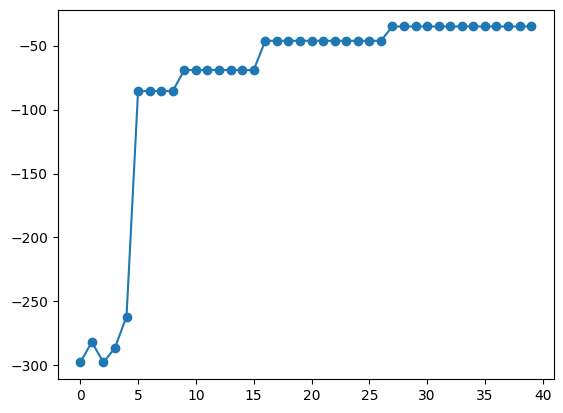

In [89]:
liste_x = [i for i in range(NB_GEN)]
liste_y = [x[1] for x in best_genome_per_gen]
plt.plot(liste_x, liste_y, '-o')
plt.show()

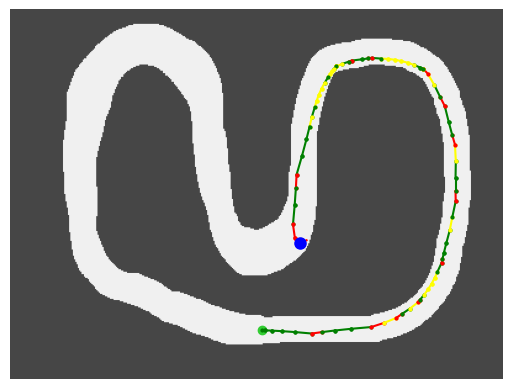

best gen: 27
-35.0199999999997


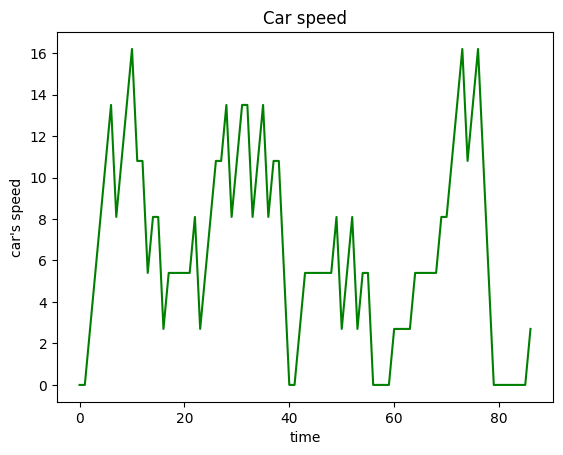

In [90]:
id_winner = 0
for i in range(len(best_genome_per_gen)):
    if best_genome_per_gen[i][1] > best_genome_per_gen[id_winner][1]:
        id_winner = i

winner = best_genome_per_gen[id_winner][0]
score = evaluate_genome(winner, config, show=True)
print("best gen:", id_winner)
print(score)

def plot_speed():
    liste_x = [i for i in range(len(env.car.trajectory)+1)]
    liste_y = [0]
    for _, speed_increase in env.car.trajectory:
        speed = 0
        if speed_increase == 1:
            speed = env.car.acceleration_constant
        elif speed_increase == -1:
            speed = -env.car.brake_constant
        liste_y.append(liste_y[-1] + speed)

    plt.plot(liste_x, liste_y, "-", color="green")
    plt.xlabel("time")
    plt.ylabel("car's speed")
    plt.title("Car speed")
    plt.show()

plot_speed()
env.close()